# EGI 2023 Tutorial - Part II:
## Analyze computation outputs
This part is designed to analyze the results from [Part I] and answer several reproducibility questions, such as:
- Are the outputs of the BraTS pipeline repeatable from one execution to another ?
- Are they reproducible between version 1.8.1 and version 1.9.0 ?
- Can we reproduce the numerical results of the [published paper](https://hal.science/hal-04006057) ?

**This Notebook will be run 2 times:**
1. While computations of [Part I] are still running, download and analyse the results of the published paper (Author: `vip-team`).
2. When most computations of [Part I] are finished, download and analyse the results of all tutorial participants (Author: `tutorial`).

[Part I]: examples/repro-brats/1-launch-application.ipynb
[vip-portal]: https://vip.creatis.insa-lyon.fr/ "https://vip.creatis.insa-lyon.fr/"

In [1]:
# Builtins
import matplotlib.pyplot as plt
from pathlib import *
# Installed
import nibabel as nib
import numpy as np
import pandas as pd
from ipywidgets import interact
from parse import parse
from scipy.ndimage import gaussian_filter

import sys
sys.path.append('../..')
from src.VipLoader import VipLoader

## Understand the application's outputs

<img src="../../imgs/BraTS-Pipeline.png" alt="BraTS-Pipeline" height="150" title="Full Pipeline for Brain Tumor Segmentation"/>

In [2]:
output_dir = PurePosixPath("/vip/EGI tutorial (group)/outputs")
res_dir = Path("data")

# output_dir = PurePosixPath("/vip/EGI tutorial (group)/outputs/vip-team")
# res_dir = Path("data/vip-team")

VipLoader.init()
VipLoader._download_dir(output_dir, res_dir)


----------------------------------
| You are communicating with VIP |
----------------------------------

Folder: data ... Already there.
Folder: data/tutorial ... Already there.
Folder: data/tutorial/v181 ... Already there.
Folder: data/tutorial/v181/16-06-2023_11:10:31 ... Already there.
Folder: data/tutorial/v190 ... Already there.
Folder: data/tutorial/v190/16-06-2023_09:47:09 ... Already there.
Folder: data/tutorial/v190/16-06-2023_11:10:49 ... 

KeyboardInterrupt: 

In [3]:
# Define a filename for each type of result
filenames = {
    "tumor": 'brainTumorMask_SRI.nii.gz',
    "brain": 'T1_to_SRI_brain.nii.gz'
}
# Get 1 tumor file and 1 brain scan
tumor_file = next(res_dir.rglob('brainTumorMask_SRI.nii.gz'))
brain_file = next(res_dir.rglob('T1_to_SRI_brain.nii.gz'))
# Display
print("\n".join([str(tumor_file), str(brain_file)]))

data/tutorial/v181/16-06-2023_11:10:31/UPENN-GBM-00019.tar.gz/UPENN-GBM-00019/brainTumorMask_SRI.nii.gz
data/tutorial/v181/16-06-2023_11:10:31/UPENN-GBM-00019.tar.gz/UPENN-GBM-00019/T1_to_SRI_brain.nii.gz


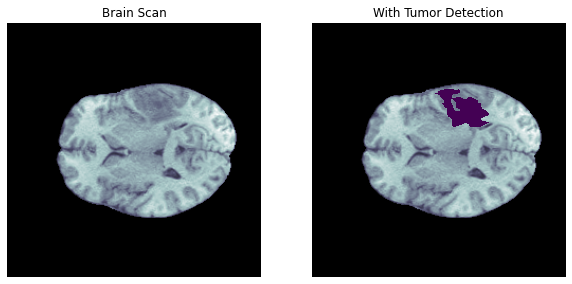

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [4]:
brain = nib.load(brain_file).get_fdata()
tumor = nib.load(tumor_file).get_fdata()
tumor[tumor==0] = np.nan

def show_tumor_2D(tumor: np.ndarray, brain: np.ndarray, ax: plt.Axes):
    ax.imshow(brain, cmap='bone', origin="lower")
    tumor[tumor==0] = np.nan
    ax.imshow(tumor, origin="lower")
    ax.axis('off')

@interact
def show_slices(z=(0,150)) -> None:
    _, (ax_brain, ax_tumor) = plt.subplots(1, 2, figsize=(10,5))

    ax_brain.set_title("Brain Scan")
    ax_brain.imshow(brain[:,:,z], cmap='bone', origin="lower")
    ax_brain.axis('off')

    ax_tumor.set_title("With Tumor Detection")
    ax_tumor.imshow(brain[:,:,z], cmap='bone', origin="lower")
    ax_tumor.imshow(tumor[:,:,z], origin="lower")
    ax_tumor.axis('off')

    plt.show()

## Compare Execution Results

In [5]:
# Get all result files
all_files = [str(path) for path in res_dir.rglob(filenames["tumor"])] \
          + [str(path) for path in res_dir.rglob(filenames["brain"])]
all_files[0]

'data/tutorial/v181/16-06-2023_11:10:31/UPENN-GBM-00019.tar.gz/UPENN-GBM-00019/brainTumorMask_SRI.nii.gz'

In [6]:
# Results are sorted by metadata
metadata_format = "{Author}/{Version}/{Execution}/{_}/{Subject}/{Filename}"
path_format = str(res_dir / metadata_format)
metadata_keys = metadata_format.replace("{","").replace("}","").split("/")
metadata_keys.remove('_')

# Function to get the metadata from 1 path as a dataframe
def get_metadata_from_path(path: str) -> dict:
    metadata = parse(path_format, path)
    if metadata is None: 
        return {}
    result = metadata.named
    result.update({"Path": path}) 
    return result

# Get all metadata as a dataframe
data = pd.DataFrame([get_metadata_from_path(file) for file in all_files])
data.head()

,Author,Version,Execution,Subject,Filename,Path
0,tutorial,v181,16-06-2023_11:10:31,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v181/16-06-2023_11:10:31/UPENN-G...
1,tutorial,v181,16-06-2023_11:10:31,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,data/tutorial/v181/16-06-2023_11:10:31/UPENN-G...
2,tutorial,v190,16-06-2023_11:10:49,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_11:10:49/UPENN-G...
3,tutorial,v190,16-06-2023_11:10:49,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_11:10:49/UPENN-G...
4,tutorial,v190,16-06-2023_09:47:09,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_09:47:09/UPENN-G...


In [7]:
# Rename executions
execution_map = {}
index = []
for version in data["Version"].unique():
    index += list(data[(data["Author"]=='tutorial') & (data["Version"]==version)].index)
    executions = data.iloc[index]["Execution"].unique()
    execution_map.update({ 
        executions[i]: "exec_%d" %i for i in range(len(executions))
    })

def map_names(group: pd.Series):
    executions = group.unique()
    execution_map = { 
        executions[i]: "exec_%d" %(i+1) for i in range(len(executions))
    }
    return group.map(execution_map)

data["Execution"] = data.groupby(["Author", "Version"], group_keys=False)["Execution"].apply(map_names)
data.head()

,Author,Version,Execution,Subject,Filename,Path
0,tutorial,v181,exec_1,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v181/16-06-2023_11:10:31/UPENN-G...
1,tutorial,v181,exec_1,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,data/tutorial/v181/16-06-2023_11:10:31/UPENN-G...
2,tutorial,v190,exec_1,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_11:10:49/UPENN-G...
3,tutorial,v190,exec_1,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_11:10:49/UPENN-G...
4,tutorial,v190,exec_2,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,data/tutorial/v190/16-06-2023_09:47:09/UPENN-G...


# Checksums

In [8]:
from hashlib import md5
def md5sum(file: str) -> str:
    """Computes the md5sum of `file`"""
    with open(file, "rb") as fid:
        return md5(fid.read()).hexdigest()

checksums = data.copy()
checksums["md5sum"] = checksums["Path"].apply(md5sum)

# Compare executions and versions
checksums.drop(columns="Path", inplace=True)
checksums.set_index(metadata_keys).unstack(["Author", "Execution"])

md5sum  \
Author                                                                     tutorial   
Execution                                                                    exec_1   
Version Subject         Filename                                                      
v181    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     f9148b0776a5747bc11422f890871f48   
                        brainTumorMask_SRI.nii.gz  ffa4be1d93358af9fd6525de09c4fcd5   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     2a83c47465694fdd5249da3139252acf   
                        brainTumorMask_SRI.nii.gz  836c9afb5bec1230a4bfa916359fa79c   
v190    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     92213e8515122b7217c10b18e1a14f4b   
                        brainTumorMask_SRI.nii.gz  6a614f4238051b776619cc3ebdaccf72   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     9cf1a2187c677412dfd1af10514e63e4   
                        brainTumorMask_SRI.nii.gz  fb948eb372ecab8fa6600eed411ecb59   

                                                                                     \
Author                                                                                
Execution                                                                    exec_2   
Version Subject         Filename                                                      
v181    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz                                  NaN   
                        brainTumorMask_SRI.nii.gz                               NaN   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz                                  NaN   
                        brainTumorMask_SRI.nii.gz                               NaN   
v190    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     92213e8515122b7217c10b18e1a14f4b   
                        brainTumorMask_SRI.nii.gz  6a614f4238051b776619cc3ebdaccf72   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     9cf1a2187c677412dfd1af10514e63e4   
                        brainTumorMask_SRI.nii.gz  fb948eb372ecab8fa6600eed411ecb59   

                                                                                     \
Author                                                                     vip-team   
Execution                                                                    exec_1   
Version Subject         Filename                                                      
v181    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     f9148b0776a5747bc11422f890871f48   
                        brainTumorMask_SRI.nii.gz  ffa4be1d93358af9fd6525de09c4fcd5   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     2a83c47465694fdd5249da3139252acf   
                        brainTumorMask_SRI.nii.gz  836c9afb5bec1230a4bfa916359fa79c   
v190    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     92213e8515122b7217c10b18e1a14f4b   
                        brainTumorMask_SRI.nii.gz  6a614f4238051b776619cc3ebdaccf72   
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     9cf1a2187c677412dfd1af10514e63e4   
                        brainTumorMask_SRI.nii.gz  fb948eb372ecab8fa6600eed411ecb59   

                                                                                     
Author                                                                               
Execution                                                                    exec_2  
Version Subject         Filename                                                     
v181    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     f9148b0776a5747bc11422f890871f48  
                        brainTumorMask_SRI.nii.gz  ffa4be1d93358af9fd6525de09c4fcd5  
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     2a83c47465694fdd5249da3139252acf  
                        brainTumorMask_SRI.nii.gz  836c9afb5bec1230a4bfa916359fa79c  
v190    UPENN-GBM-00019 T1_to_SRI_brain.nii.gz     92213e8515122b7217c10b18e1a14f4b  
                        brainTumorMask_SRI.nii.gz  6a614f4238051b776619cc3ebdaccf72  
        UPENN-GBM-00239 T1_to_SRI_brain.nii.gz     9cf1a2187c677412dfd1af10514e63e

# Differences

In [9]:
# Select 1 execution
execution = "exec_1"
author = "tutorial"
images = data.query("Execution==@execution & Author==@author").reset_index(drop=True)

# Pre-load all files from subject and execution
def load(file: str) -> str:
    """Computes the md5sum of `file`"""
    with open(file, "rb") as fid:
        return nib.load(file)
images["Img"] = images["Path"].apply(load)

images.drop(columns=["Execution", "Path"], inplace=True)
images.head()

,Author,Version,Subject,Filename,Img
0,tutorial,v181,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,tutorial,v181,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,tutorial,v190,UPENN-GBM-00019,brainTumorMask_SRI.nii.gz,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,tutorial,v190,UPENN-GBM-00239,brainTumorMask_SRI.nii.gz,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,tutorial,v181,UPENN-GBM-00019,T1_to_SRI_brain.nii.gz,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [10]:

# To make the images type more understandable, we map each filename to its type
filetypes = {
    'brainTumorMask_SRI.nii.gz': "tumor",
    'T1_to_SRI_brain.nii.gz': "brain",
}
images["Result"] = images.pop("Filename").map(filetypes)

# Sort the dataframe
subjects = images["Subject"].unique()
images.set_index(["Result", "Version", "Subject"], inplace=True)
images

Author  \
Result Version Subject                     
tumor  v181    UPENN-GBM-00019  tutorial   
               UPENN-GBM-00239  tutorial   
       v190    UPENN-GBM-00019  tutorial   
               UPENN-GBM-00239  tutorial   
brain  v181    UPENN-GBM-00019  tutorial   
               UPENN-GBM-00239  tutorial   
       v190    UPENN-GBM-00019  tutorial   
               UPENN-GBM-00239  tutorial   

                                                                              Img  
Result Version Subject                                                             
tumor  v181    UPENN-GBM-00019  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
               UPENN-GBM-00239  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
       v190    UPENN-GBM-00019  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
               UPENN-GBM-00239  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
brain  v181    UPENN-GBM-00019  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
               UPENN-GBM-00239  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
       v190    UPENN-GBM-00019  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
               UPENN-GBM-00239  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...

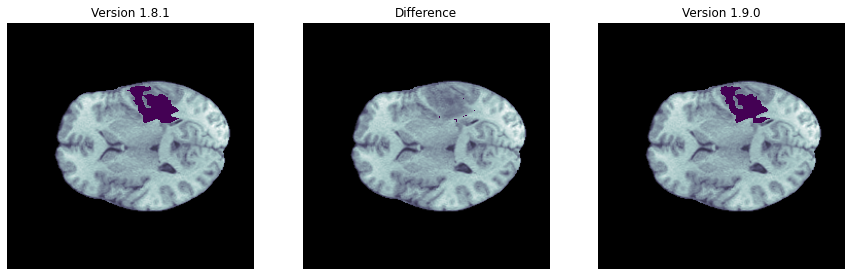

interactive(children=(IntSlider(value=75, description='z', max=150), FloatSlider(value=0.0, description='sigma…

In [12]:
def show_tumor(tumor: np.ndarray, brain: np.ndarray, ax: plt.Axes=plt):
    if brain is not None:
        ax.imshow(brain, cmap='bone', origin="lower")
    tumor[tumor==0] = np.nan
    ax.imshow(tumor, origin="lower")
    ax.axis('off')

def make_diff(tumor_a, tumor_b):
    values = np.unique(tumor_a)
    diff = np.zeros(np.shape(tumor_a))
    for val in values:
        diff[(tumor_a == val) ^ (tumor_b == val)] = val
    return diff

@interact
def show_diff(z=(0,150), sigma=(0, 1, 0.1), subject=subjects):

    brain = images["Img"]["brain", "v181", subject].get_fdata()[:,:,z]
    _, (ax_181, ax_diff, ax_190) = plt.subplots(1, 3, figsize=(15,5))

    tumor_181 = images["Img"]["tumor", "v181", subject].get_fdata()[:,:,z]
    show_tumor(tumor_181, brain, ax_181)
    ax_181.set_title("Version 1.8.1")
    
    tumor_190 = images["Img"]["tumor", "v190", subject].get_fdata()[:,:,z]
    show_tumor(tumor_190, brain, ax_190)
    ax_190.set_title("Version 1.9.0")

    tumor_diff = make_diff(tumor_181, tumor_190)
    tumor_diff = gaussian_filter(tumor_diff, sigma=sigma)
    show_tumor(tumor_diff, brain, ax_diff)
    ax_diff.set_title("Difference")

    plt.show()